In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rewards, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [9]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rewards, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    # glossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
    #                                                                 labels=tf.nn.sigmoid(targetQs))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    ###################################################
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    # dlossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
    #                                                                 labels=tf.nn.sigmoid(targetQs))) # 0-1
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    ######################################################
    actions_pred = tf.argmax(input=actions_logits, axis=1, output_type=actions.dtype)
    mask_equal = tf.equal(x=actions_pred, y=actions)
    gQs_equal = tf.boolean_mask(mask=mask_equal, tensor=gQs)
    #if len(gQs_equal) > 0:
    if gQs_equal.shape[0] > 0:
        rates_equal = tf.boolean_mask(mask=mask_equal, tensor=rates)
        dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
                                                                        labels=rates_equal)) # 0-1
        targetQs_equal = tf.boolean_mask(mask=mask_equal, tensor=targetQs)
        # dlossQ += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
        #                                                                 labels=tf.nn.sigmoid(targetQs_equal))) # 0-1
        dlossQ += tf.reduce_mean(tf.square(gQs_equal - targetQs_equal)) # DQN
    ########################################################
    mask_notequal = tf.not_equal(x=actions_pred, y=actions)
    gQs_notequal = tf.boolean_mask(mask=mask_notequal, tensor=gQs)
    #if len(gQs_notequal) > 0:
    if gQs_notequal.shape[0] > 0:
        dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_notequal, # GAN
                                                                        labels=tf.zeros_like(gQs_notequal))) # 0-1
        rewards_notequal = tf.boolean_mask(mask=mask_notequal, tensor=rewards)
        dlossQ += tf.reduce_mean(tf.square(gQs_notequal - rewards_notequal)) # DQN
    return actions_logits, gQs, gloss, glossQ, dloss, dlossQ, gQs_notequal, gQs_equal

In [10]:
def model_opt(g_loss, g_lossQ, d_loss, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        g_optQ = tf.train.AdamOptimizer(g_learning_rate).minimize(g_lossQ, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)
    return g_opt, g_optQ, d_opt, d_optQ

In [11]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rewards, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.g_lossQ, self.d_loss, self.d_lossQ, self.gQs_notequal, self.gQs_equal = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            rewards=self.rewards, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.g_optQ, self.d_opt, self.d_optQ = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                                                     g_lossQ=self.g_lossQ, d_lossQ=self.d_lossQ,
                                                                     g_learning_rate=g_learning_rate, 
                                                                     d_learning_rate=d_learning_rate)

In [12]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [14]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [15]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [16]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, _ = sess.run([model.d_loss, model.d_opt], feed_dict = {model.states: states, 
                                                                          model.actions: actions,
                                                                          model.rewards: rewards,
                                                                          model.targetQs: targetQs, 
                                                                          model.rates: rates})
            dlossQ, _ = sess.run([model.d_lossQ, model.d_optQ], feed_dict = {model.states: states, 
                                                                             model.actions: actions,
                                                                             model.rewards: rewards,
                                                                             model.targetQs: targetQs, 
                                                                             model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt], feed_dict = {model.states: states, 
                                                                          model.actions: actions,
                                                                          model.rewards: rewards,
                                                                          model.targetQs: targetQs, 
                                                                          model.rates: rates})
            glossQ, _ = sess.run([model.g_lossQ, model.g_optQ], feed_dict = {model.states: states, 
                                                                             model.actions: actions,
                                                                             model.rewards: rewards,
                                                                             model.targetQs: targetQs, 
                                                                             model.rates: rates})
            # #if len(gQs_nonequal) != len(nextQs):
            # #if dloss is np.nan:            
            # if len(gQs_notequal) < 2:            
            # print(gQs_notequal.shape, gQs_notequal.dtype)
            # print(gQs_equal.shape, gQs_equal.dtype)
            # print(nextQs.shape)
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:21.0000 R:21.0000 rate:0.0420 gloss:0.7024 glossQ:1.0045 dloss:0.4989 dlossQ:2.9215 exploreP:0.9979
Episode:1 meanR:19.5000 R:18.0000 rate:0.0360 gloss:0.7027 glossQ:1.0059 dloss:0.4980 dlossQ:2.9114 exploreP:0.9961
Episode:2 meanR:18.0000 R:15.0000 rate:0.0300 gloss:0.6913 glossQ:1.0055 dloss:0.4942 dlossQ:2.8707 exploreP:0.9947
Episode:3 meanR:18.7500 R:21.0000 rate:0.0420 gloss:0.7019 glossQ:1.0046 dloss:0.5015 dlossQ:2.9096 exploreP:0.9926
Episode:4 meanR:19.2000 R:21.0000 rate:0.0420 gloss:0.6989 glossQ:1.0053 dloss:0.4934 dlossQ:2.8996 exploreP:0.9905
Episode:5 meanR:21.3333 R:32.0000 rate:0.0640 gloss:0.6961 glossQ:1.0051 dloss:0.4985 dlossQ:2.8838 exploreP:0.9874
Episode:6 meanR:20.5714 R:16.0000 rate:0.0320 gloss:0.6972 glossQ:1.0052 dloss:0.4879 dlossQ:2.8941 exploreP:0.9858
Episode:7 meanR:19.5000 R:12.0000 rate:0.0240 gloss:0.6979 glossQ:1.0050 dloss:0.4906 dlossQ:2.8800 exploreP:0.9847
Episode:8 meanR:21.6667 R:39.0000 rate:0.0780 gloss:0.6940 glossQ:1.0055

Episode:71 meanR:22.1528 R:23.0000 rate:0.0460 gloss:0.6999 glossQ:1.0040 dloss:0.5004 dlossQ:2.8726 exploreP:0.8540
Episode:72 meanR:22.1918 R:25.0000 rate:0.0500 gloss:0.7009 glossQ:1.0040 dloss:0.4908 dlossQ:2.8711 exploreP:0.8519
Episode:73 meanR:22.0676 R:13.0000 rate:0.0260 gloss:0.7047 glossQ:1.0042 dloss:0.5165 dlossQ:2.8994 exploreP:0.8508
Episode:74 meanR:21.9067 R:10.0000 rate:0.0200 gloss:0.6961 glossQ:1.0032 dloss:0.4987 dlossQ:2.8264 exploreP:0.8500
Episode:75 meanR:21.7763 R:12.0000 rate:0.0240 gloss:0.6964 glossQ:1.0049 dloss:0.4926 dlossQ:2.8668 exploreP:0.8490
Episode:76 meanR:21.7143 R:17.0000 rate:0.0340 gloss:0.6954 glossQ:1.0041 dloss:0.5004 dlossQ:2.8273 exploreP:0.8476
Episode:77 meanR:21.7949 R:28.0000 rate:0.0560 gloss:0.6962 glossQ:1.0047 dloss:0.5018 dlossQ:2.8542 exploreP:0.8452
Episode:78 meanR:22.0380 R:41.0000 rate:0.0820 gloss:0.6967 glossQ:1.0044 dloss:0.4921 dlossQ:2.8588 exploreP:0.8418
Episode:79 meanR:21.9375 R:14.0000 rate:0.0280 gloss:0.6902 glos

Episode:141 meanR:23.2900 R:10.0000 rate:0.0200 gloss:0.6948 glossQ:1.0043 dloss:0.4998 dlossQ:2.8111 exploreP:0.7310
Episode:142 meanR:23.1600 R:11.0000 rate:0.0220 gloss:0.6968 glossQ:1.0125 dloss:0.4905 dlossQ:2.8436 exploreP:0.7303
Episode:143 meanR:22.8400 R:9.0000 rate:0.0180 gloss:0.6946 glossQ:1.0044 dloss:0.4891 dlossQ:2.8376 exploreP:0.7296
Episode:144 meanR:22.9200 R:22.0000 rate:0.0440 gloss:0.6960 glossQ:1.0033 dloss:0.4947 dlossQ:2.8255 exploreP:0.7280
Episode:145 meanR:22.9600 R:17.0000 rate:0.0340 gloss:0.6920 glossQ:1.0041 dloss:0.5017 dlossQ:2.8287 exploreP:0.7268
Episode:146 meanR:22.4600 R:13.0000 rate:0.0260 gloss:0.6905 glossQ:1.0051 dloss:0.4906 dlossQ:2.8150 exploreP:0.7259
Episode:147 meanR:22.5700 R:32.0000 rate:0.0640 gloss:0.6955 glossQ:1.0045 dloss:0.4957 dlossQ:2.8308 exploreP:0.7236
Episode:148 meanR:22.4900 R:19.0000 rate:0.0380 gloss:0.6982 glossQ:0.9912 dloss:0.5032 dlossQ:2.8117 exploreP:0.7222
Episode:149 meanR:22.1200 R:20.0000 rate:0.0400 gloss:0.7

Episode:211 meanR:19.4100 R:16.0000 rate:0.0320 gloss:0.6926 glossQ:0.9972 dloss:0.4944 dlossQ:2.8219 exploreP:0.6430
Episode:212 meanR:19.4100 R:11.0000 rate:0.0220 gloss:0.6949 glossQ:1.0033 dloss:0.4860 dlossQ:2.8241 exploreP:0.6423
Episode:213 meanR:19.1900 R:10.0000 rate:0.0200 gloss:0.6933 glossQ:1.0035 dloss:0.4925 dlossQ:2.8063 exploreP:0.6416
Episode:214 meanR:18.9900 R:26.0000 rate:0.0520 gloss:0.6951 glossQ:1.0032 dloss:0.4949 dlossQ:2.8069 exploreP:0.6400
Episode:215 meanR:18.8900 R:11.0000 rate:0.0220 gloss:0.6900 glossQ:1.0102 dloss:0.5041 dlossQ:2.8159 exploreP:0.6393
Episode:216 meanR:18.8600 R:10.0000 rate:0.0200 gloss:0.6938 glossQ:1.0031 dloss:0.5017 dlossQ:2.7724 exploreP:0.6387
Episode:217 meanR:18.8900 R:11.0000 rate:0.0220 gloss:0.6970 glossQ:1.0029 dloss:0.5059 dlossQ:2.8180 exploreP:0.6380
Episode:218 meanR:19.0800 R:31.0000 rate:0.0620 gloss:0.6961 glossQ:1.0031 dloss:0.4996 dlossQ:2.8103 exploreP:0.6360
Episode:219 meanR:19.0800 R:13.0000 rate:0.0260 gloss:0.

Episode:281 meanR:17.3500 R:9.0000 rate:0.0180 gloss:0.6926 glossQ:1.0009 dloss:0.5051 dlossQ:2.7940 exploreP:0.5754
Episode:282 meanR:17.4300 R:18.0000 rate:0.0360 gloss:0.6961 glossQ:1.0034 dloss:0.4957 dlossQ:2.7970 exploreP:0.5744
Episode:283 meanR:17.3700 R:11.0000 rate:0.0220 gloss:0.7018 glossQ:1.0022 dloss:0.4984 dlossQ:2.8270 exploreP:0.5737
Episode:284 meanR:17.1800 R:16.0000 rate:0.0320 gloss:0.6962 glossQ:1.0031 dloss:0.4911 dlossQ:2.7928 exploreP:0.5728
Episode:285 meanR:17.2100 R:16.0000 rate:0.0320 gloss:0.6990 glossQ:1.0023 dloss:0.5009 dlossQ:2.8109 exploreP:0.5719
Episode:286 meanR:17.1100 R:12.0000 rate:0.0240 gloss:0.6962 glossQ:1.0021 dloss:0.4988 dlossQ:2.7874 exploreP:0.5713
Episode:287 meanR:17.0500 R:10.0000 rate:0.0200 gloss:0.6927 glossQ:1.0004 dloss:0.4986 dlossQ:2.7976 exploreP:0.5707
Episode:288 meanR:16.9900 R:11.0000 rate:0.0220 gloss:0.6989 glossQ:1.0022 dloss:0.4957 dlossQ:2.8001 exploreP:0.5701
Episode:289 meanR:16.9700 R:13.0000 rate:0.0260 gloss:0.6

Episode:351 meanR:15.5100 R:24.0000 rate:0.0480 gloss:0.6986 glossQ:1.0022 dloss:0.4982 dlossQ:2.7938 exploreP:0.5203
Episode:352 meanR:15.3200 R:12.0000 rate:0.0240 gloss:0.6965 glossQ:1.0018 dloss:0.4984 dlossQ:2.7948 exploreP:0.5196
Episode:353 meanR:15.2800 R:10.0000 rate:0.0200 gloss:0.6914 glossQ:1.0031 dloss:0.5018 dlossQ:2.7493 exploreP:0.5191
Episode:354 meanR:15.5600 R:39.0000 rate:0.0780 gloss:0.6938 glossQ:1.0010 dloss:0.4969 dlossQ:2.7751 exploreP:0.5171
Episode:355 meanR:15.5600 R:11.0000 rate:0.0220 gloss:0.6918 glossQ:1.0033 dloss:0.4923 dlossQ:2.7889 exploreP:0.5166
Episode:356 meanR:15.6200 R:17.0000 rate:0.0340 gloss:0.6919 glossQ:1.0030 dloss:0.5091 dlossQ:2.7742 exploreP:0.5157
Episode:357 meanR:15.6200 R:11.0000 rate:0.0220 gloss:0.6988 glossQ:1.0023 dloss:0.5007 dlossQ:2.8029 exploreP:0.5152
Episode:358 meanR:15.6200 R:14.0000 rate:0.0280 gloss:0.6900 glossQ:1.0036 dloss:0.5004 dlossQ:2.7893 exploreP:0.5145
Episode:359 meanR:15.7100 R:19.0000 rate:0.0380 gloss:0.

Episode:421 meanR:14.0000 R:10.0000 rate:0.0200 gloss:0.6959 glossQ:1.0015 dloss:0.4959 dlossQ:2.7789 exploreP:0.4730
Episode:422 meanR:13.8800 R:10.0000 rate:0.0200 gloss:0.6969 glossQ:1.0027 dloss:0.5051 dlossQ:2.7929 exploreP:0.4726
Episode:423 meanR:13.8500 R:17.0000 rate:0.0340 gloss:0.6986 glossQ:1.0021 dloss:0.4927 dlossQ:2.7901 exploreP:0.4718
Episode:424 meanR:13.8900 R:14.0000 rate:0.0280 gloss:0.6928 glossQ:1.0038 dloss:0.4948 dlossQ:2.7796 exploreP:0.4711
Episode:425 meanR:14.0000 R:21.0000 rate:0.0420 gloss:0.6953 glossQ:1.0014 dloss:0.4992 dlossQ:2.7621 exploreP:0.4702
Episode:426 meanR:13.9700 R:11.0000 rate:0.0220 gloss:0.6971 glossQ:1.0024 dloss:0.5018 dlossQ:2.7909 exploreP:0.4697
Episode:427 meanR:13.9900 R:24.0000 rate:0.0480 gloss:0.6921 glossQ:1.0025 dloss:0.4925 dlossQ:2.7714 exploreP:0.4686
Episode:428 meanR:13.9900 R:12.0000 rate:0.0240 gloss:0.6952 glossQ:1.0032 dloss:0.4921 dlossQ:2.7845 exploreP:0.4680
Episode:429 meanR:13.9100 R:13.0000 rate:0.0260 gloss:0.

Episode:491 meanR:12.7200 R:9.0000 rate:0.0180 gloss:0.6902 glossQ:1.0022 dloss:0.4854 dlossQ:2.7452 exploreP:0.4334
Episode:492 meanR:12.7000 R:8.0000 rate:0.0160 gloss:0.6890 glossQ:1.0024 dloss:0.4924 dlossQ:2.7301 exploreP:0.4330
Episode:493 meanR:12.6600 R:12.0000 rate:0.0240 gloss:0.6939 glossQ:1.0025 dloss:0.4941 dlossQ:2.7670 exploreP:0.4325
Episode:494 meanR:12.6400 R:9.0000 rate:0.0180 gloss:0.6914 glossQ:1.0022 dloss:0.4895 dlossQ:2.7520 exploreP:0.4321
Episode:495 meanR:12.6600 R:12.0000 rate:0.0240 gloss:0.6909 glossQ:1.0031 dloss:0.4922 dlossQ:2.7427 exploreP:0.4316
Episode:496 meanR:12.7900 R:22.0000 rate:0.0440 gloss:0.6946 glossQ:1.0020 dloss:0.4938 dlossQ:2.7600 exploreP:0.4307
Episode:497 meanR:12.8600 R:15.0000 rate:0.0300 gloss:0.6944 glossQ:1.0006 dloss:0.4980 dlossQ:2.7615 exploreP:0.4301
Episode:498 meanR:12.5800 R:9.0000 rate:0.0180 gloss:0.6941 glossQ:1.0027 dloss:0.4973 dlossQ:2.7656 exploreP:0.4297
Episode:499 meanR:12.6200 R:17.0000 rate:0.0340 gloss:0.6929

Episode:561 meanR:12.6000 R:11.0000 rate:0.0220 gloss:0.6948 glossQ:1.0018 dloss:0.4873 dlossQ:2.7673 exploreP:0.3980
Episode:562 meanR:12.6100 R:15.0000 rate:0.0300 gloss:0.6936 glossQ:1.0019 dloss:0.4931 dlossQ:2.7515 exploreP:0.3974
Episode:563 meanR:12.7300 R:23.0000 rate:0.0460 gloss:0.6934 glossQ:1.0073 dloss:0.4985 dlossQ:2.7594 exploreP:0.3965
Episode:564 meanR:12.7300 R:11.0000 rate:0.0220 gloss:0.6903 glossQ:1.0024 dloss:0.5041 dlossQ:2.7406 exploreP:0.3961
Episode:565 meanR:12.7500 R:12.0000 rate:0.0240 gloss:0.6944 glossQ:1.0015 dloss:0.5016 dlossQ:2.7588 exploreP:0.3956
Episode:566 meanR:12.8700 R:27.0000 rate:0.0540 gloss:0.6894 glossQ:1.0039 dloss:0.4989 dlossQ:2.7500 exploreP:0.3946
Episode:567 meanR:12.9000 R:13.0000 rate:0.0260 gloss:0.6856 glossQ:1.0034 dloss:0.5000 dlossQ:2.7256 exploreP:0.3941
Episode:568 meanR:12.8900 R:11.0000 rate:0.0220 gloss:0.6903 glossQ:1.0023 dloss:0.4889 dlossQ:2.7494 exploreP:0.3936
Episode:569 meanR:12.8600 R:12.0000 rate:0.0240 gloss:0.

Episode:631 meanR:12.4600 R:11.0000 rate:0.0220 gloss:0.6942 glossQ:1.0021 dloss:0.5061 dlossQ:2.7323 exploreP:0.3651
Episode:632 meanR:12.4400 R:10.0000 rate:0.0200 gloss:0.6912 glossQ:1.0027 dloss:0.4910 dlossQ:2.7614 exploreP:0.3648
Episode:633 meanR:12.3600 R:10.0000 rate:0.0200 gloss:0.6955 glossQ:1.0028 dloss:0.5011 dlossQ:2.7779 exploreP:0.3644
Episode:634 meanR:12.4300 R:17.0000 rate:0.0340 gloss:0.6934 glossQ:1.0021 dloss:0.4921 dlossQ:2.7456 exploreP:0.3638
Episode:635 meanR:12.4300 R:11.0000 rate:0.0220 gloss:0.6965 glossQ:1.0017 dloss:0.5016 dlossQ:2.7697 exploreP:0.3634
Episode:636 meanR:12.4400 R:10.0000 rate:0.0200 gloss:0.6948 glossQ:1.0013 dloss:0.4947 dlossQ:2.7565 exploreP:0.3631
Episode:637 meanR:12.4200 R:8.0000 rate:0.0160 gloss:0.6907 glossQ:1.0025 dloss:0.5046 dlossQ:2.7415 exploreP:0.3628
Episode:638 meanR:12.3500 R:8.0000 rate:0.0160 gloss:0.6973 glossQ:1.0021 dloss:0.5070 dlossQ:2.7460 exploreP:0.3625
Episode:639 meanR:12.3400 R:9.0000 rate:0.0180 gloss:0.696

Episode:701 meanR:11.9000 R:19.0000 rate:0.0380 gloss:0.6909 glossQ:1.0025 dloss:0.5018 dlossQ:2.7437 exploreP:0.3370
Episode:702 meanR:11.8900 R:10.0000 rate:0.0200 gloss:0.6968 glossQ:1.0017 dloss:0.5049 dlossQ:2.7344 exploreP:0.3367
Episode:703 meanR:11.8700 R:11.0000 rate:0.0220 gloss:0.6975 glossQ:1.0024 dloss:0.4912 dlossQ:2.7625 exploreP:0.3363
Episode:704 meanR:11.8000 R:11.0000 rate:0.0220 gloss:0.6889 glossQ:1.0026 dloss:0.4922 dlossQ:2.7098 exploreP:0.3360
Episode:705 meanR:11.8300 R:13.0000 rate:0.0260 gloss:0.6961 glossQ:1.0022 dloss:0.4898 dlossQ:2.7486 exploreP:0.3355
Episode:706 meanR:11.7900 R:8.0000 rate:0.0160 gloss:0.6977 glossQ:1.0019 dloss:0.5121 dlossQ:2.7374 exploreP:0.3353
Episode:707 meanR:11.7700 R:9.0000 rate:0.0180 gloss:0.6955 glossQ:1.0025 dloss:0.4970 dlossQ:2.7544 exploreP:0.3350
Episode:708 meanR:11.7900 R:10.0000 rate:0.0200 gloss:0.6967 glossQ:1.0020 dloss:0.4990 dlossQ:2.7580 exploreP:0.3347
Episode:709 meanR:11.7700 R:13.0000 rate:0.0260 gloss:0.69

Episode:771 meanR:11.4900 R:13.0000 rate:0.0260 gloss:0.6936 glossQ:1.0019 dloss:0.4954 dlossQ:2.7563 exploreP:0.3120
Episode:772 meanR:11.5100 R:14.0000 rate:0.0280 gloss:0.6958 glossQ:1.0012 dloss:0.5048 dlossQ:2.7394 exploreP:0.3116
Episode:773 meanR:11.5300 R:13.0000 rate:0.0260 gloss:0.6929 glossQ:1.0020 dloss:0.4975 dlossQ:2.7320 exploreP:0.3112
Episode:774 meanR:11.5200 R:11.0000 rate:0.0220 gloss:0.6943 glossQ:1.0016 dloss:0.5000 dlossQ:2.7443 exploreP:0.3109
Episode:775 meanR:11.5300 R:11.0000 rate:0.0220 gloss:0.6941 glossQ:1.0016 dloss:0.5148 dlossQ:2.7217 exploreP:0.3105
Episode:776 meanR:11.4900 R:10.0000 rate:0.0200 gloss:0.6859 glossQ:1.0065 dloss:0.4820 dlossQ:2.7454 exploreP:0.3102
Episode:777 meanR:11.4900 R:10.0000 rate:0.0200 gloss:0.6941 glossQ:1.0007 dloss:0.4971 dlossQ:2.7441 exploreP:0.3099
Episode:778 meanR:11.5000 R:11.0000 rate:0.0220 gloss:0.6902 glossQ:1.0026 dloss:0.4931 dlossQ:2.7396 exploreP:0.3096
Episode:779 meanR:11.4700 R:9.0000 rate:0.0180 gloss:0.6

Episode:841 meanR:11.0300 R:14.0000 rate:0.0280 gloss:0.6930 glossQ:1.0018 dloss:0.5028 dlossQ:2.7025 exploreP:0.2900
Episode:842 meanR:11.0200 R:14.0000 rate:0.0280 gloss:0.6930 glossQ:1.0021 dloss:0.4976 dlossQ:2.7167 exploreP:0.2896
Episode:843 meanR:11.0000 R:9.0000 rate:0.0180 gloss:0.7004 glossQ:1.0012 dloss:0.4945 dlossQ:2.7284 exploreP:0.2893
Episode:844 meanR:11.0600 R:15.0000 rate:0.0300 gloss:0.6952 glossQ:1.0019 dloss:0.5047 dlossQ:2.7204 exploreP:0.2889
Episode:845 meanR:11.0200 R:8.0000 rate:0.0160 gloss:0.6939 glossQ:1.0013 dloss:0.4984 dlossQ:2.7226 exploreP:0.2887
Episode:846 meanR:11.0400 R:15.0000 rate:0.0300 gloss:0.6951 glossQ:1.0019 dloss:0.5031 dlossQ:2.7352 exploreP:0.2883
Episode:847 meanR:11.0100 R:9.0000 rate:0.0180 gloss:0.6887 glossQ:1.0033 dloss:0.4979 dlossQ:2.7364 exploreP:0.2880
Episode:848 meanR:11.0200 R:10.0000 rate:0.0200 gloss:0.6925 glossQ:1.0021 dloss:0.4883 dlossQ:2.7201 exploreP:0.2877
Episode:849 meanR:11.0000 R:8.0000 rate:0.0160 gloss:0.6943

Episode:911 meanR:10.7200 R:10.0000 rate:0.0200 gloss:0.6919 glossQ:1.0021 dloss:0.5060 dlossQ:2.7165 exploreP:0.2694
Episode:912 meanR:10.7300 R:11.0000 rate:0.0220 gloss:0.6950 glossQ:0.9994 dloss:0.5028 dlossQ:2.7255 exploreP:0.2691
Episode:913 meanR:10.7600 R:11.0000 rate:0.0220 gloss:0.6938 glossQ:1.0022 dloss:0.4895 dlossQ:2.7285 exploreP:0.2688
Episode:914 meanR:10.7700 R:10.0000 rate:0.0200 gloss:0.6895 glossQ:1.0022 dloss:0.4932 dlossQ:2.6984 exploreP:0.2686
Episode:915 meanR:10.7900 R:10.0000 rate:0.0200 gloss:0.6922 glossQ:1.0018 dloss:0.5010 dlossQ:2.7059 exploreP:0.2683
Episode:916 meanR:10.8800 R:17.0000 rate:0.0340 gloss:0.6921 glossQ:1.0014 dloss:0.4955 dlossQ:2.7241 exploreP:0.2679
Episode:917 meanR:10.8700 R:10.0000 rate:0.0200 gloss:0.6999 glossQ:1.0010 dloss:0.4859 dlossQ:2.7300 exploreP:0.2676
Episode:918 meanR:10.8900 R:12.0000 rate:0.0240 gloss:0.6964 glossQ:1.0019 dloss:0.4924 dlossQ:2.7375 exploreP:0.2673
Episode:919 meanR:10.8800 R:10.0000 rate:0.0200 gloss:0.

Episode:981 meanR:10.7500 R:10.0000 rate:0.0200 gloss:0.6911 glossQ:1.0022 dloss:0.5004 dlossQ:2.7308 exploreP:0.2506
Episode:982 meanR:10.7200 R:10.0000 rate:0.0200 gloss:0.6868 glossQ:1.0031 dloss:0.4975 dlossQ:2.7131 exploreP:0.2504
Episode:983 meanR:10.6900 R:9.0000 rate:0.0180 gloss:0.6943 glossQ:1.0020 dloss:0.4933 dlossQ:2.7275 exploreP:0.2502
Episode:984 meanR:10.6800 R:10.0000 rate:0.0200 gloss:0.6937 glossQ:1.0016 dloss:0.4987 dlossQ:2.7073 exploreP:0.2499
Episode:985 meanR:10.6600 R:9.0000 rate:0.0180 gloss:0.6991 glossQ:1.0013 dloss:0.4997 dlossQ:2.7230 exploreP:0.2497
Episode:986 meanR:10.6800 R:12.0000 rate:0.0240 gloss:0.6931 glossQ:1.0020 dloss:0.4888 dlossQ:2.7246 exploreP:0.2494
Episode:987 meanR:10.6700 R:10.0000 rate:0.0200 gloss:0.6922 glossQ:1.0012 dloss:0.4930 dlossQ:2.7073 exploreP:0.2492
Episode:988 meanR:10.6900 R:13.0000 rate:0.0260 gloss:0.6938 glossQ:1.0017 dloss:0.5068 dlossQ:2.7180 exploreP:0.2489
Episode:989 meanR:10.7200 R:13.0000 rate:0.0260 gloss:0.69

Episode:1051 meanR:10.7000 R:9.0000 rate:0.0180 gloss:0.6988 glossQ:1.0009 dloss:0.4902 dlossQ:2.7345 exploreP:0.2331
Episode:1052 meanR:10.7400 R:12.0000 rate:0.0240 gloss:0.6976 glossQ:1.0020 dloss:0.4935 dlossQ:2.7237 exploreP:0.2329
Episode:1053 meanR:10.7000 R:8.0000 rate:0.0160 gloss:0.6962 glossQ:1.0010 dloss:0.4985 dlossQ:2.7087 exploreP:0.2327
Episode:1054 meanR:10.6800 R:10.0000 rate:0.0200 gloss:0.7000 glossQ:1.0013 dloss:0.4906 dlossQ:2.7186 exploreP:0.2325
Episode:1055 meanR:10.6300 R:9.0000 rate:0.0180 gloss:0.6906 glossQ:1.0024 dloss:0.4916 dlossQ:2.7092 exploreP:0.2323
Episode:1056 meanR:10.6500 R:11.0000 rate:0.0220 gloss:0.6948 glossQ:1.0018 dloss:0.4992 dlossQ:2.7178 exploreP:0.2320
Episode:1057 meanR:10.6700 R:13.0000 rate:0.0260 gloss:0.7002 glossQ:1.0016 dloss:0.4947 dlossQ:2.7389 exploreP:0.2317
Episode:1058 meanR:10.6900 R:12.0000 rate:0.0240 gloss:0.6942 glossQ:1.0017 dloss:0.5028 dlossQ:2.6965 exploreP:0.2315
Episode:1059 meanR:10.7200 R:13.0000 rate:0.0260 gl

Episode:1121 meanR:10.6500 R:10.0000 rate:0.0200 gloss:0.6971 glossQ:1.0012 dloss:0.4957 dlossQ:2.7100 exploreP:0.2169
Episode:1122 meanR:10.5800 R:9.0000 rate:0.0180 gloss:0.6921 glossQ:0.9980 dloss:0.4955 dlossQ:2.7219 exploreP:0.2167
Episode:1123 meanR:10.6000 R:12.0000 rate:0.0240 gloss:0.6960 glossQ:1.0022 dloss:0.4978 dlossQ:2.7163 exploreP:0.2165
Episode:1124 meanR:10.6100 R:12.0000 rate:0.0240 gloss:0.6907 glossQ:1.0020 dloss:0.4999 dlossQ:2.6916 exploreP:0.2162
Episode:1125 meanR:10.6400 R:11.0000 rate:0.0220 gloss:0.6921 glossQ:0.9962 dloss:0.5037 dlossQ:2.7140 exploreP:0.2160
Episode:1126 meanR:10.6400 R:9.0000 rate:0.0180 gloss:0.6912 glossQ:1.0024 dloss:0.4951 dlossQ:2.7118 exploreP:0.2158
Episode:1127 meanR:10.6600 R:11.0000 rate:0.0220 gloss:0.6899 glossQ:1.0027 dloss:0.5042 dlossQ:2.6876 exploreP:0.2156
Episode:1128 meanR:10.6700 R:10.0000 rate:0.0200 gloss:0.6908 glossQ:1.0009 dloss:0.4951 dlossQ:2.7134 exploreP:0.2154
Episode:1129 meanR:10.6400 R:10.0000 rate:0.0200 g

Episode:1191 meanR:10.6700 R:9.0000 rate:0.0180 gloss:0.6924 glossQ:1.0018 dloss:0.5182 dlossQ:2.6650 exploreP:0.2019
Episode:1192 meanR:10.7000 R:14.0000 rate:0.0280 gloss:0.6914 glossQ:1.0022 dloss:0.4974 dlossQ:2.6836 exploreP:0.2017
Episode:1193 meanR:10.7100 R:12.0000 rate:0.0240 gloss:0.6907 glossQ:1.0018 dloss:0.4951 dlossQ:2.6773 exploreP:0.2014
Episode:1194 meanR:10.7300 R:11.0000 rate:0.0220 gloss:0.6967 glossQ:1.0008 dloss:0.5070 dlossQ:2.6901 exploreP:0.2012
Episode:1195 meanR:10.7000 R:10.0000 rate:0.0200 gloss:0.6932 glossQ:1.0017 dloss:0.4934 dlossQ:2.7002 exploreP:0.2010
Episode:1196 meanR:10.7200 R:12.0000 rate:0.0240 gloss:0.6805 glossQ:1.0209 dloss:0.5085 dlossQ:2.6777 exploreP:0.2008
Episode:1197 meanR:10.6700 R:9.0000 rate:0.0180 gloss:0.6952 glossQ:1.0016 dloss:0.5104 dlossQ:2.6906 exploreP:0.2006
Episode:1198 meanR:10.6800 R:10.0000 rate:0.0200 gloss:0.6953 glossQ:1.0016 dloss:0.4928 dlossQ:2.6999 exploreP:0.2004
Episode:1199 meanR:10.6800 R:9.0000 rate:0.0180 gl

Episode:1261 meanR:10.5500 R:11.0000 rate:0.0220 gloss:0.6942 glossQ:1.0028 dloss:0.4963 dlossQ:2.6861 exploreP:0.1883
Episode:1262 meanR:10.5400 R:11.0000 rate:0.0220 gloss:0.6930 glossQ:1.0034 dloss:0.4802 dlossQ:2.7142 exploreP:0.1881
Episode:1263 meanR:10.5300 R:9.0000 rate:0.0180 gloss:0.6862 glossQ:1.0030 dloss:0.4954 dlossQ:2.6636 exploreP:0.1879
Episode:1264 meanR:10.5400 R:10.0000 rate:0.0200 gloss:0.6923 glossQ:1.0032 dloss:0.5028 dlossQ:2.7038 exploreP:0.1877
Episode:1265 meanR:10.5400 R:10.0000 rate:0.0200 gloss:0.6959 glossQ:1.0020 dloss:0.4943 dlossQ:2.6986 exploreP:0.1875
Episode:1266 meanR:10.5300 R:10.0000 rate:0.0200 gloss:0.6892 glossQ:1.0027 dloss:0.4924 dlossQ:2.6447 exploreP:0.1874
Episode:1267 meanR:10.5700 R:17.0000 rate:0.0340 gloss:0.6989 glossQ:1.0014 dloss:0.4967 dlossQ:2.6931 exploreP:0.1871
Episode:1268 meanR:10.5500 R:14.0000 rate:0.0280 gloss:0.6913 glossQ:1.0022 dloss:0.4964 dlossQ:2.6871 exploreP:0.1868
Episode:1269 meanR:10.5500 R:9.0000 rate:0.0180 g

Episode:1331 meanR:10.5400 R:11.0000 rate:0.0220 gloss:0.6981 glossQ:1.0020 dloss:0.5039 dlossQ:2.6974 exploreP:0.1757
Episode:1332 meanR:10.5400 R:10.0000 rate:0.0200 gloss:0.6959 glossQ:1.0020 dloss:0.4947 dlossQ:2.6849 exploreP:0.1755
Episode:1333 meanR:10.5700 R:12.0000 rate:0.0240 gloss:0.7032 glossQ:1.0013 dloss:0.5020 dlossQ:2.7007 exploreP:0.1753
Episode:1334 meanR:10.5400 R:9.0000 rate:0.0180 gloss:0.6884 glossQ:1.0028 dloss:0.5104 dlossQ:2.6649 exploreP:0.1752
Episode:1335 meanR:10.5400 R:9.0000 rate:0.0180 gloss:0.6855 glossQ:1.0048 dloss:0.4964 dlossQ:2.6846 exploreP:0.1750
Episode:1336 meanR:10.5200 R:9.0000 rate:0.0180 gloss:0.6958 glossQ:1.0009 dloss:0.5000 dlossQ:2.6835 exploreP:0.1749
Episode:1337 meanR:10.5000 R:9.0000 rate:0.0180 gloss:0.6989 glossQ:1.0020 dloss:0.4950 dlossQ:2.6697 exploreP:0.1747
Episode:1338 meanR:10.5100 R:11.0000 rate:0.0220 gloss:0.7021 glossQ:1.0018 dloss:0.5036 dlossQ:2.6992 exploreP:0.1745
Episode:1339 meanR:10.5000 R:9.0000 rate:0.0180 glos

Episode:1401 meanR:10.3700 R:11.0000 rate:0.0220 gloss:0.6885 glossQ:1.0035 dloss:0.5000 dlossQ:2.6383 exploreP:0.1641
Episode:1402 meanR:10.3300 R:10.0000 rate:0.0200 gloss:0.6882 glossQ:1.0026 dloss:0.5074 dlossQ:2.6361 exploreP:0.1639
Episode:1403 meanR:10.3500 R:14.0000 rate:0.0280 gloss:0.7033 glossQ:1.0016 dloss:0.4904 dlossQ:2.7006 exploreP:0.1637
Episode:1404 meanR:10.3300 R:9.0000 rate:0.0180 gloss:0.6866 glossQ:1.0036 dloss:0.4998 dlossQ:2.6289 exploreP:0.1636
Episode:1405 meanR:10.3500 R:12.0000 rate:0.0240 gloss:0.6933 glossQ:1.0018 dloss:0.4983 dlossQ:2.6792 exploreP:0.1634
Episode:1406 meanR:10.3900 R:12.0000 rate:0.0240 gloss:0.6901 glossQ:1.0011 dloss:0.4953 dlossQ:2.6728 exploreP:0.1632
Episode:1407 meanR:10.4200 R:13.0000 rate:0.0260 gloss:0.7014 glossQ:1.0015 dloss:0.4863 dlossQ:2.6926 exploreP:0.1630
Episode:1408 meanR:10.4300 R:10.0000 rate:0.0200 gloss:0.6913 glossQ:1.0026 dloss:0.4972 dlossQ:2.6760 exploreP:0.1629
Episode:1409 meanR:10.4200 R:9.0000 rate:0.0180 g

Episode:1471 meanR:10.4600 R:11.0000 rate:0.0220 gloss:0.6965 glossQ:1.0037 dloss:0.4976 dlossQ:2.6674 exploreP:0.1533
Episode:1472 meanR:10.4500 R:11.0000 rate:0.0220 gloss:0.6976 glossQ:1.0013 dloss:0.4950 dlossQ:2.6705 exploreP:0.1531
Episode:1473 meanR:10.4400 R:10.0000 rate:0.0200 gloss:0.6966 glossQ:1.0022 dloss:0.4967 dlossQ:2.7014 exploreP:0.1530
Episode:1474 meanR:10.4300 R:9.0000 rate:0.0180 gloss:0.6839 glossQ:1.0065 dloss:0.5041 dlossQ:2.6709 exploreP:0.1528
Episode:1475 meanR:10.3400 R:9.0000 rate:0.0180 gloss:0.6948 glossQ:1.0019 dloss:0.5017 dlossQ:2.6821 exploreP:0.1527
Episode:1476 meanR:10.3700 R:11.0000 rate:0.0220 gloss:0.6959 glossQ:1.0038 dloss:0.4968 dlossQ:2.6976 exploreP:0.1525
Episode:1477 meanR:10.3800 R:11.0000 rate:0.0220 gloss:0.6922 glossQ:1.0024 dloss:0.4957 dlossQ:2.6710 exploreP:0.1524
Episode:1478 meanR:10.3700 R:10.0000 rate:0.0200 gloss:0.6994 glossQ:1.0014 dloss:0.5044 dlossQ:2.6718 exploreP:0.1522
Episode:1479 meanR:10.3900 R:11.0000 rate:0.0220 g

Episode:1541 meanR:10.3500 R:11.0000 rate:0.0220 gloss:0.7083 glossQ:0.9968 dloss:0.4920 dlossQ:2.7019 exploreP:0.1433
Episode:1542 meanR:10.3500 R:9.0000 rate:0.0180 gloss:0.6917 glossQ:1.0020 dloss:0.5029 dlossQ:2.6501 exploreP:0.1432
Episode:1543 meanR:10.3600 R:9.0000 rate:0.0180 gloss:0.6971 glossQ:1.0019 dloss:0.4984 dlossQ:2.6874 exploreP:0.1431
Episode:1544 meanR:10.3500 R:10.0000 rate:0.0200 gloss:0.7020 glossQ:1.0023 dloss:0.4925 dlossQ:2.6916 exploreP:0.1430
Episode:1545 meanR:10.3500 R:9.0000 rate:0.0180 gloss:0.6873 glossQ:1.0026 dloss:0.5008 dlossQ:2.6632 exploreP:0.1428
Episode:1546 meanR:10.3300 R:10.0000 rate:0.0200 gloss:0.6937 glossQ:1.0032 dloss:0.4873 dlossQ:2.6741 exploreP:0.1427
Episode:1547 meanR:10.3200 R:11.0000 rate:0.0220 gloss:0.6982 glossQ:1.0018 dloss:0.4952 dlossQ:2.6868 exploreP:0.1426
Episode:1548 meanR:10.3300 R:14.0000 rate:0.0280 gloss:0.6940 glossQ:1.0017 dloss:0.5017 dlossQ:2.6658 exploreP:0.1424
Episode:1549 meanR:10.3100 R:10.0000 rate:0.0200 gl

Episode:1611 meanR:10.2300 R:12.0000 rate:0.0240 gloss:0.7092 glossQ:0.9870 dloss:0.4978 dlossQ:2.6971 exploreP:0.1342
Episode:1612 meanR:10.2000 R:10.0000 rate:0.0200 gloss:0.6994 glossQ:1.0019 dloss:0.5024 dlossQ:2.6558 exploreP:0.1341
Episode:1613 meanR:10.2000 R:10.0000 rate:0.0200 gloss:0.6884 glossQ:1.0027 dloss:0.5014 dlossQ:2.6388 exploreP:0.1339
Episode:1614 meanR:10.1900 R:9.0000 rate:0.0180 gloss:0.6856 glossQ:1.0025 dloss:0.4952 dlossQ:2.6253 exploreP:0.1338
Episode:1615 meanR:10.1700 R:10.0000 rate:0.0200 gloss:0.6883 glossQ:1.0034 dloss:0.4920 dlossQ:2.6354 exploreP:0.1337
Episode:1616 meanR:10.1600 R:8.0000 rate:0.0160 gloss:0.6912 glossQ:1.0037 dloss:0.4893 dlossQ:2.6784 exploreP:0.1336
Episode:1617 meanR:10.1500 R:8.0000 rate:0.0160 gloss:0.6992 glossQ:1.0021 dloss:0.4956 dlossQ:2.6787 exploreP:0.1335
Episode:1618 meanR:10.1700 R:10.0000 rate:0.0200 gloss:0.7003 glossQ:1.0012 dloss:0.5075 dlossQ:2.6589 exploreP:0.1334
Episode:1619 meanR:10.1800 R:10.0000 rate:0.0200 gl

Episode:1681 meanR:10.1500 R:10.0000 rate:0.0200 gloss:0.6896 glossQ:1.0036 dloss:0.5068 dlossQ:2.6156 exploreP:0.1257
Episode:1682 meanR:10.1300 R:9.0000 rate:0.0180 gloss:0.6908 glossQ:1.0027 dloss:0.4973 dlossQ:2.6243 exploreP:0.1256
Episode:1683 meanR:10.1200 R:12.0000 rate:0.0240 gloss:0.6936 glossQ:1.0020 dloss:0.5025 dlossQ:2.6536 exploreP:0.1254
Episode:1684 meanR:10.1200 R:10.0000 rate:0.0200 gloss:0.6985 glossQ:1.0017 dloss:0.4933 dlossQ:2.6600 exploreP:0.1253
Episode:1685 meanR:10.1100 R:9.0000 rate:0.0180 gloss:0.7066 glossQ:1.0015 dloss:0.4821 dlossQ:2.6901 exploreP:0.1252
Episode:1686 meanR:10.1000 R:9.0000 rate:0.0180 gloss:0.6874 glossQ:1.0039 dloss:0.5103 dlossQ:2.6184 exploreP:0.1251
Episode:1687 meanR:10.0900 R:10.0000 rate:0.0200 gloss:0.6984 glossQ:1.0024 dloss:0.4906 dlossQ:2.6546 exploreP:0.1250
Episode:1688 meanR:10.0600 R:9.0000 rate:0.0180 gloss:0.6856 glossQ:1.0030 dloss:0.5069 dlossQ:2.6245 exploreP:0.1249
Episode:1689 meanR:10.0700 R:11.0000 rate:0.0220 glo

Episode:1751 meanR:10.1000 R:9.0000 rate:0.0180 gloss:0.6967 glossQ:1.0024 dloss:0.5051 dlossQ:2.6490 exploreP:0.1178
Episode:1752 meanR:10.0900 R:9.0000 rate:0.0180 gloss:0.6991 glossQ:1.0027 dloss:0.5004 dlossQ:2.6643 exploreP:0.1177
Episode:1753 meanR:10.1000 R:9.0000 rate:0.0180 gloss:0.7007 glossQ:1.0027 dloss:0.4864 dlossQ:2.6547 exploreP:0.1176
Episode:1754 meanR:10.0900 R:8.0000 rate:0.0160 gloss:0.6924 glossQ:1.0027 dloss:0.5070 dlossQ:2.6471 exploreP:0.1175
Episode:1755 meanR:10.0400 R:10.0000 rate:0.0200 gloss:0.6911 glossQ:1.0037 dloss:0.4924 dlossQ:2.6528 exploreP:0.1174
Episode:1756 meanR:10.0300 R:9.0000 rate:0.0180 gloss:0.7000 glossQ:1.0018 dloss:0.4993 dlossQ:2.6618 exploreP:0.1173
Episode:1757 meanR:10.0100 R:9.0000 rate:0.0180 gloss:0.7004 glossQ:1.0046 dloss:0.4944 dlossQ:2.6498 exploreP:0.1172
Episode:1758 meanR:10.0000 R:10.0000 rate:0.0200 gloss:0.6974 glossQ:1.0021 dloss:0.4961 dlossQ:2.6480 exploreP:0.1171
Episode:1759 meanR:10.0400 R:14.0000 rate:0.0280 gloss

Episode:1821 meanR:9.9200 R:10.0000 rate:0.0200 gloss:0.7055 glossQ:1.0022 dloss:0.5078 dlossQ:2.6370 exploreP:0.1106
Episode:1822 meanR:9.8900 R:9.0000 rate:0.0180 gloss:0.6932 glossQ:1.0023 dloss:0.5097 dlossQ:2.6310 exploreP:0.1105
Episode:1823 meanR:9.9300 R:13.0000 rate:0.0260 gloss:0.6962 glossQ:1.0023 dloss:0.5083 dlossQ:2.6431 exploreP:0.1103
Episode:1824 meanR:9.9400 R:11.0000 rate:0.0220 gloss:0.6913 glossQ:1.0034 dloss:0.5143 dlossQ:2.5638 exploreP:0.1102
Episode:1825 meanR:9.9300 R:9.0000 rate:0.0180 gloss:0.6946 glossQ:1.0027 dloss:0.4946 dlossQ:2.6329 exploreP:0.1101
Episode:1826 meanR:9.9200 R:10.0000 rate:0.0200 gloss:0.7060 glossQ:1.0018 dloss:0.4948 dlossQ:2.6446 exploreP:0.1100
Episode:1827 meanR:9.9000 R:9.0000 rate:0.0180 gloss:0.6968 glossQ:1.0028 dloss:0.4965 dlossQ:2.6381 exploreP:0.1099
Episode:1828 meanR:9.9200 R:11.0000 rate:0.0220 gloss:0.6870 glossQ:1.0032 dloss:0.4995 dlossQ:2.6326 exploreP:0.1098
Episode:1829 meanR:9.9300 R:10.0000 rate:0.0200 gloss:0.700

Episode:1891 meanR:9.8500 R:10.0000 rate:0.0200 gloss:0.7009 glossQ:1.0023 dloss:0.4913 dlossQ:2.6314 exploreP:0.1038
Episode:1892 meanR:9.8500 R:9.0000 rate:0.0180 gloss:0.7018 glossQ:1.0017 dloss:0.5035 dlossQ:2.6469 exploreP:0.1038
Episode:1893 meanR:9.8600 R:11.0000 rate:0.0220 gloss:0.6978 glossQ:1.0016 dloss:0.5049 dlossQ:2.6246 exploreP:0.1037
Episode:1894 meanR:9.8800 R:12.0000 rate:0.0240 gloss:0.7124 glossQ:1.0011 dloss:0.4948 dlossQ:2.6750 exploreP:0.1035
Episode:1895 meanR:9.8600 R:9.0000 rate:0.0180 gloss:0.6933 glossQ:1.0023 dloss:0.5034 dlossQ:2.6027 exploreP:0.1035
Episode:1896 meanR:9.8500 R:9.0000 rate:0.0180 gloss:0.6966 glossQ:1.0018 dloss:0.5013 dlossQ:2.6438 exploreP:0.1034
Episode:1897 meanR:9.8400 R:9.0000 rate:0.0180 gloss:0.6946 glossQ:1.0020 dloss:0.4968 dlossQ:2.6143 exploreP:0.1033
Episode:1898 meanR:9.8400 R:10.0000 rate:0.0200 gloss:0.7067 glossQ:1.0035 dloss:0.5088 dlossQ:2.5951 exploreP:0.1032
Episode:1899 meanR:9.8300 R:9.0000 rate:0.0180 gloss:0.7094 

Episode:1961 meanR:9.8600 R:11.0000 rate:0.0220 gloss:0.6938 glossQ:1.0026 dloss:0.4977 dlossQ:2.6339 exploreP:0.0976
Episode:1962 meanR:9.8400 R:8.0000 rate:0.0160 gloss:0.6766 glossQ:1.0078 dloss:0.4902 dlossQ:2.6383 exploreP:0.0975
Episode:1963 meanR:9.8600 R:11.0000 rate:0.0220 gloss:0.7116 glossQ:1.0013 dloss:0.4994 dlossQ:2.6467 exploreP:0.0974
Episode:1964 meanR:9.8500 R:8.0000 rate:0.0160 gloss:0.7151 glossQ:1.0029 dloss:0.4971 dlossQ:2.6500 exploreP:0.0973
Episode:1965 meanR:9.8300 R:9.0000 rate:0.0180 gloss:0.6925 glossQ:1.0025 dloss:0.5024 dlossQ:2.6195 exploreP:0.0972
Episode:1966 meanR:9.8300 R:10.0000 rate:0.0200 gloss:0.6971 glossQ:1.0027 dloss:0.5046 dlossQ:2.6353 exploreP:0.0972
Episode:1967 meanR:9.8400 R:10.0000 rate:0.0200 gloss:0.7098 glossQ:1.0019 dloss:0.4998 dlossQ:2.6329 exploreP:0.0971
Episode:1968 meanR:9.8700 R:13.0000 rate:0.0260 gloss:0.6974 glossQ:1.0028 dloss:0.4932 dlossQ:2.6357 exploreP:0.0970
Episode:1969 meanR:9.8800 R:10.0000 rate:0.0200 gloss:0.695

Episode:2031 meanR:9.9200 R:11.0000 rate:0.0220 gloss:0.6899 glossQ:1.0034 dloss:0.5104 dlossQ:2.5674 exploreP:0.0917
Episode:2032 meanR:9.9300 R:9.0000 rate:0.0180 gloss:0.7127 glossQ:1.0031 dloss:0.4902 dlossQ:2.6578 exploreP:0.0916
Episode:2033 meanR:9.9200 R:9.0000 rate:0.0180 gloss:0.6948 glossQ:1.0029 dloss:0.4985 dlossQ:2.6329 exploreP:0.0915
Episode:2034 meanR:9.9200 R:10.0000 rate:0.0200 gloss:0.6960 glossQ:1.0013 dloss:0.5116 dlossQ:2.6166 exploreP:0.0915
Episode:2035 meanR:9.9500 R:11.0000 rate:0.0220 gloss:0.6861 glossQ:1.0035 dloss:0.5059 dlossQ:2.5946 exploreP:0.0914
Episode:2036 meanR:9.9400 R:9.0000 rate:0.0180 gloss:0.7019 glossQ:1.0033 dloss:0.4906 dlossQ:2.6233 exploreP:0.0913
Episode:2037 meanR:9.9500 R:10.0000 rate:0.0200 gloss:0.6835 glossQ:1.0039 dloss:0.5005 dlossQ:2.5820 exploreP:0.0912
Episode:2038 meanR:9.9700 R:11.0000 rate:0.0220 gloss:0.6985 glossQ:1.0026 dloss:0.4992 dlossQ:2.6148 exploreP:0.0911
Episode:2039 meanR:9.9800 R:10.0000 rate:0.0200 gloss:0.697

Episode:2101 meanR:9.9600 R:10.0000 rate:0.0200 gloss:0.7039 glossQ:1.0015 dloss:0.5079 dlossQ:2.6371 exploreP:0.0862
Episode:2102 meanR:9.9600 R:10.0000 rate:0.0200 gloss:0.6858 glossQ:1.0032 dloss:0.5189 dlossQ:2.5764 exploreP:0.0861
Episode:2103 meanR:9.9600 R:10.0000 rate:0.0200 gloss:0.6901 glossQ:1.0038 dloss:0.4964 dlossQ:2.5923 exploreP:0.0860
Episode:2104 meanR:9.9600 R:9.0000 rate:0.0180 gloss:0.7027 glossQ:1.0030 dloss:0.4922 dlossQ:2.6293 exploreP:0.0860
Episode:2105 meanR:9.9100 R:8.0000 rate:0.0160 gloss:0.6829 glossQ:1.0037 dloss:0.4969 dlossQ:2.5819 exploreP:0.0859
Episode:2106 meanR:9.9100 R:9.0000 rate:0.0180 gloss:0.6979 glossQ:1.0017 dloss:0.5052 dlossQ:2.6159 exploreP:0.0858
Episode:2107 meanR:9.9200 R:10.0000 rate:0.0200 gloss:0.6993 glossQ:1.0026 dloss:0.5051 dlossQ:2.6110 exploreP:0.0857
Episode:2108 meanR:9.9200 R:10.0000 rate:0.0200 gloss:0.7114 glossQ:1.0012 dloss:0.5047 dlossQ:2.6368 exploreP:0.0857
Episode:2109 meanR:9.9200 R:10.0000 rate:0.0200 gloss:0.691

Episode:2171 meanR:9.9500 R:8.0000 rate:0.0160 gloss:0.6866 glossQ:1.0039 dloss:0.5060 dlossQ:2.5934 exploreP:0.0812
Episode:2172 meanR:9.9800 R:12.0000 rate:0.0240 gloss:0.6949 glossQ:1.0028 dloss:0.5041 dlossQ:2.6017 exploreP:0.0811
Episode:2173 meanR:9.9900 R:11.0000 rate:0.0220 gloss:0.6995 glossQ:1.0007 dloss:0.5015 dlossQ:2.5902 exploreP:0.0810
Episode:2174 meanR:9.9800 R:9.0000 rate:0.0180 gloss:0.7006 glossQ:1.0030 dloss:0.5030 dlossQ:2.6080 exploreP:0.0809
Episode:2175 meanR:9.9800 R:10.0000 rate:0.0200 gloss:0.7115 glossQ:1.0015 dloss:0.4940 dlossQ:2.6389 exploreP:0.0809
Episode:2176 meanR:9.9700 R:9.0000 rate:0.0180 gloss:0.6863 glossQ:1.0036 dloss:0.5158 dlossQ:2.5794 exploreP:0.0808
Episode:2177 meanR:9.9600 R:10.0000 rate:0.0200 gloss:0.7019 glossQ:1.0016 dloss:0.5016 dlossQ:2.6293 exploreP:0.0807
Episode:2178 meanR:9.9500 R:9.0000 rate:0.0180 gloss:0.7002 glossQ:1.0022 dloss:0.4969 dlossQ:2.6064 exploreP:0.0807
Episode:2179 meanR:9.9400 R:9.0000 rate:0.0180 gloss:0.7104 

Episode:2241 meanR:9.8600 R:10.0000 rate:0.0200 gloss:0.7057 glossQ:1.0025 dloss:0.5046 dlossQ:2.6037 exploreP:0.0764
Episode:2242 meanR:9.8500 R:10.0000 rate:0.0200 gloss:0.7122 glossQ:1.0002 dloss:0.4975 dlossQ:2.6112 exploreP:0.0763
Episode:2243 meanR:9.8500 R:9.0000 rate:0.0180 gloss:0.6955 glossQ:1.0037 dloss:0.5035 dlossQ:2.5880 exploreP:0.0763
Episode:2244 meanR:9.8400 R:9.0000 rate:0.0180 gloss:0.6977 glossQ:1.0015 dloss:0.5037 dlossQ:2.5775 exploreP:0.0762
Episode:2245 meanR:9.8500 R:9.0000 rate:0.0180 gloss:0.7066 glossQ:1.0025 dloss:0.5112 dlossQ:2.6122 exploreP:0.0761
Episode:2246 meanR:9.8500 R:9.0000 rate:0.0180 gloss:0.6937 glossQ:1.0029 dloss:0.5061 dlossQ:2.5911 exploreP:0.0761
Episode:2247 meanR:9.8500 R:9.0000 rate:0.0180 gloss:0.7038 glossQ:1.0049 dloss:0.4849 dlossQ:2.6100 exploreP:0.0760
Episode:2248 meanR:9.8400 R:9.0000 rate:0.0180 gloss:0.7002 glossQ:1.0039 dloss:0.5012 dlossQ:2.6271 exploreP:0.0760
Episode:2249 meanR:9.8300 R:10.0000 rate:0.0200 gloss:0.7031 g

Episode:2311 meanR:9.7700 R:10.0000 rate:0.0200 gloss:0.6938 glossQ:1.0037 dloss:0.5015 dlossQ:2.5977 exploreP:0.0720
Episode:2312 meanR:9.7900 R:11.0000 rate:0.0220 gloss:0.7124 glossQ:1.0011 dloss:0.5057 dlossQ:2.6111 exploreP:0.0720
Episode:2313 meanR:9.7900 R:9.0000 rate:0.0180 gloss:0.7025 glossQ:1.0022 dloss:0.5078 dlossQ:2.5922 exploreP:0.0719
Episode:2314 meanR:9.7800 R:9.0000 rate:0.0180 gloss:0.7127 glossQ:1.0025 dloss:0.4961 dlossQ:2.5957 exploreP:0.0719
Episode:2315 meanR:9.7300 R:8.0000 rate:0.0160 gloss:0.7122 glossQ:1.0016 dloss:0.4931 dlossQ:2.6211 exploreP:0.0718
Episode:2316 meanR:9.7200 R:9.0000 rate:0.0180 gloss:0.7028 glossQ:1.0030 dloss:0.5072 dlossQ:2.5627 exploreP:0.0718
Episode:2317 meanR:9.7100 R:10.0000 rate:0.0200 gloss:0.7056 glossQ:1.0000 dloss:0.4978 dlossQ:2.6170 exploreP:0.0717
Episode:2318 meanR:9.7200 R:10.0000 rate:0.0200 gloss:0.7111 glossQ:1.0038 dloss:0.4898 dlossQ:2.6286 exploreP:0.0716
Episode:2319 meanR:9.6900 R:9.0000 rate:0.0180 gloss:0.6967 

Episode:2381 meanR:9.9100 R:10.0000 rate:0.0200 gloss:0.7040 glossQ:1.0028 dloss:0.5029 dlossQ:2.5973 exploreP:0.0679
Episode:2382 meanR:9.9100 R:10.0000 rate:0.0200 gloss:0.6997 glossQ:1.0023 dloss:0.5034 dlossQ:2.5977 exploreP:0.0678
Episode:2383 meanR:9.9200 R:10.0000 rate:0.0200 gloss:0.7117 glossQ:1.0014 dloss:0.5083 dlossQ:2.5966 exploreP:0.0678
Episode:2384 meanR:9.9000 R:9.0000 rate:0.0180 gloss:0.6926 glossQ:1.0031 dloss:0.5018 dlossQ:2.5647 exploreP:0.0677
Episode:2385 meanR:9.8900 R:10.0000 rate:0.0200 gloss:0.6927 glossQ:1.0033 dloss:0.5077 dlossQ:2.5785 exploreP:0.0676
Episode:2386 meanR:9.9000 R:10.0000 rate:0.0200 gloss:0.7010 glossQ:1.0038 dloss:0.5017 dlossQ:2.5893 exploreP:0.0676
Episode:2387 meanR:9.8800 R:8.0000 rate:0.0160 gloss:0.7028 glossQ:1.0038 dloss:0.5016 dlossQ:2.5682 exploreP:0.0675
Episode:2388 meanR:9.9000 R:11.0000 rate:0.0220 gloss:0.6950 glossQ:1.0029 dloss:0.5056 dlossQ:2.5560 exploreP:0.0675
Episode:2389 meanR:9.9100 R:10.0000 rate:0.0200 gloss:0.68

Episode:2451 meanR:9.8600 R:10.0000 rate:0.0200 gloss:0.6964 glossQ:1.0043 dloss:0.5098 dlossQ:2.5516 exploreP:0.0640
Episode:2452 meanR:9.8700 R:11.0000 rate:0.0220 gloss:0.7082 glossQ:1.0020 dloss:0.5091 dlossQ:2.5787 exploreP:0.0640
Episode:2453 meanR:9.8600 R:10.0000 rate:0.0200 gloss:0.7053 glossQ:1.0025 dloss:0.5072 dlossQ:2.5790 exploreP:0.0639
Episode:2454 meanR:9.8500 R:10.0000 rate:0.0200 gloss:0.6937 glossQ:1.0065 dloss:0.4992 dlossQ:2.5200 exploreP:0.0639
Episode:2455 meanR:9.8500 R:10.0000 rate:0.0200 gloss:0.6864 glossQ:1.0037 dloss:0.5068 dlossQ:2.5627 exploreP:0.0638
Episode:2456 meanR:9.8400 R:9.0000 rate:0.0180 gloss:0.7081 glossQ:0.9978 dloss:0.5056 dlossQ:2.6012 exploreP:0.0638
Episode:2457 meanR:9.8500 R:11.0000 rate:0.0220 gloss:0.6981 glossQ:1.0041 dloss:0.5023 dlossQ:2.5488 exploreP:0.0637
Episode:2458 meanR:9.8500 R:9.0000 rate:0.0180 gloss:0.7004 glossQ:1.0015 dloss:0.5021 dlossQ:2.5791 exploreP:0.0637
Episode:2459 meanR:9.8100 R:8.0000 rate:0.0160 gloss:0.713

Episode:2521 meanR:9.5300 R:11.0000 rate:0.0220 gloss:0.6942 glossQ:1.0046 dloss:0.5065 dlossQ:2.5604 exploreP:0.0606
Episode:2522 meanR:9.5300 R:10.0000 rate:0.0200 gloss:0.7103 glossQ:1.0022 dloss:0.5113 dlossQ:2.5777 exploreP:0.0605
Episode:2523 meanR:9.5300 R:10.0000 rate:0.0200 gloss:0.7069 glossQ:1.0032 dloss:0.5073 dlossQ:2.5554 exploreP:0.0605
Episode:2524 meanR:9.5300 R:10.0000 rate:0.0200 gloss:0.6817 glossQ:1.0056 dloss:0.5010 dlossQ:2.5364 exploreP:0.0604
Episode:2525 meanR:9.5200 R:9.0000 rate:0.0180 gloss:0.6954 glossQ:1.0029 dloss:0.5095 dlossQ:2.5495 exploreP:0.0604
Episode:2526 meanR:9.5100 R:9.0000 rate:0.0180 gloss:0.6962 glossQ:1.0025 dloss:0.5121 dlossQ:2.5533 exploreP:0.0603
Episode:2527 meanR:9.4900 R:10.0000 rate:0.0200 gloss:0.7126 glossQ:1.0010 dloss:0.5164 dlossQ:2.5902 exploreP:0.0603
Episode:2528 meanR:9.5100 R:12.0000 rate:0.0240 gloss:0.6996 glossQ:1.0029 dloss:0.5087 dlossQ:2.5660 exploreP:0.0602
Episode:2529 meanR:9.4900 R:9.0000 rate:0.0180 gloss:0.714

Episode:2591 meanR:9.6700 R:8.0000 rate:0.0160 gloss:0.7113 glossQ:1.0020 dloss:0.5042 dlossQ:2.5131 exploreP:0.0572
Episode:2592 meanR:9.6800 R:11.0000 rate:0.0220 gloss:0.7082 glossQ:1.0026 dloss:0.5118 dlossQ:2.5387 exploreP:0.0572
Episode:2593 meanR:9.7000 R:12.0000 rate:0.0240 gloss:0.7041 glossQ:1.0024 dloss:0.5050 dlossQ:2.5559 exploreP:0.0571
Episode:2594 meanR:9.7100 R:10.0000 rate:0.0200 gloss:0.6954 glossQ:1.0028 dloss:0.5145 dlossQ:2.5382 exploreP:0.0571
Episode:2595 meanR:9.7100 R:10.0000 rate:0.0200 gloss:0.7014 glossQ:1.0029 dloss:0.5075 dlossQ:2.5245 exploreP:0.0570
Episode:2596 meanR:9.7100 R:9.0000 rate:0.0180 gloss:0.6989 glossQ:1.0018 dloss:0.5106 dlossQ:2.5392 exploreP:0.0570
Episode:2597 meanR:9.7000 R:8.0000 rate:0.0160 gloss:0.7084 glossQ:1.0025 dloss:0.5113 dlossQ:2.5487 exploreP:0.0570
Episode:2598 meanR:9.6900 R:8.0000 rate:0.0160 gloss:0.7079 glossQ:1.0016 dloss:0.5045 dlossQ:2.5814 exploreP:0.0569
Episode:2599 meanR:9.7100 R:12.0000 rate:0.0240 gloss:0.7041

Episode:2661 meanR:9.6200 R:9.0000 rate:0.0180 gloss:0.7116 glossQ:1.0021 dloss:0.5043 dlossQ:2.5676 exploreP:0.0542
Episode:2662 meanR:9.6200 R:9.0000 rate:0.0180 gloss:0.7011 glossQ:1.0024 dloss:0.5107 dlossQ:2.5531 exploreP:0.0541
Episode:2663 meanR:9.5900 R:8.0000 rate:0.0160 gloss:0.6868 glossQ:1.0082 dloss:0.5128 dlossQ:2.4780 exploreP:0.0541
Episode:2664 meanR:9.5800 R:10.0000 rate:0.0200 gloss:0.7154 glossQ:1.0014 dloss:0.5097 dlossQ:2.5421 exploreP:0.0540
Episode:2665 meanR:9.5700 R:9.0000 rate:0.0180 gloss:0.6838 glossQ:1.0054 dloss:0.5067 dlossQ:2.5154 exploreP:0.0540
Episode:2666 meanR:9.5500 R:8.0000 rate:0.0160 gloss:0.6958 glossQ:1.0030 dloss:0.5160 dlossQ:2.5269 exploreP:0.0540
Episode:2667 meanR:9.5600 R:10.0000 rate:0.0200 gloss:0.7046 glossQ:1.0032 dloss:0.5037 dlossQ:2.5514 exploreP:0.0539
Episode:2668 meanR:9.5500 R:9.0000 rate:0.0180 gloss:0.7089 glossQ:1.0044 dloss:0.5073 dlossQ:2.5601 exploreP:0.0539
Episode:2669 meanR:9.5400 R:8.0000 rate:0.0160 gloss:0.7062 gl

Episode:2731 meanR:9.4600 R:10.0000 rate:0.0200 gloss:0.7053 glossQ:1.0038 dloss:0.5108 dlossQ:2.5513 exploreP:0.0513
Episode:2732 meanR:9.4800 R:10.0000 rate:0.0200 gloss:0.6947 glossQ:1.0041 dloss:0.4961 dlossQ:2.5552 exploreP:0.0513
Episode:2733 meanR:9.4900 R:11.0000 rate:0.0220 gloss:0.7277 glossQ:1.0017 dloss:0.5053 dlossQ:2.5382 exploreP:0.0513
Episode:2734 meanR:9.5000 R:10.0000 rate:0.0200 gloss:0.6983 glossQ:1.0035 dloss:0.5092 dlossQ:2.5428 exploreP:0.0512
Episode:2735 meanR:9.5000 R:9.0000 rate:0.0180 gloss:0.7003 glossQ:1.0026 dloss:0.5192 dlossQ:2.5688 exploreP:0.0512
Episode:2736 meanR:9.5100 R:10.0000 rate:0.0200 gloss:0.7055 glossQ:1.0033 dloss:0.5082 dlossQ:2.5708 exploreP:0.0511
Episode:2737 meanR:9.5200 R:10.0000 rate:0.0200 gloss:0.7109 glossQ:1.0025 dloss:0.5133 dlossQ:2.5490 exploreP:0.0511
Episode:2738 meanR:9.5200 R:9.0000 rate:0.0180 gloss:0.7062 glossQ:1.0026 dloss:0.5113 dlossQ:2.5672 exploreP:0.0511
Episode:2739 meanR:9.5100 R:9.0000 rate:0.0180 gloss:0.710

Episode:2801 meanR:9.6600 R:9.0000 rate:0.0180 gloss:0.7089 glossQ:1.0018 dloss:0.5146 dlossQ:2.5681 exploreP:0.0486
Episode:2802 meanR:9.6800 R:10.0000 rate:0.0200 gloss:0.7228 glossQ:0.9981 dloss:0.5056 dlossQ:2.5736 exploreP:0.0486
Episode:2803 meanR:9.6800 R:10.0000 rate:0.0200 gloss:0.7071 glossQ:1.0024 dloss:0.5247 dlossQ:2.5062 exploreP:0.0486
Episode:2804 meanR:9.6500 R:8.0000 rate:0.0160 gloss:0.7050 glossQ:1.0029 dloss:0.5084 dlossQ:2.5194 exploreP:0.0485
Episode:2805 meanR:9.6600 R:10.0000 rate:0.0200 gloss:0.7040 glossQ:1.0030 dloss:0.5103 dlossQ:2.5246 exploreP:0.0485
Episode:2806 meanR:9.6700 R:11.0000 rate:0.0220 gloss:0.7239 glossQ:1.0016 dloss:0.5099 dlossQ:2.5410 exploreP:0.0484
Episode:2807 meanR:9.6800 R:10.0000 rate:0.0200 gloss:0.7271 glossQ:1.0008 dloss:0.5078 dlossQ:2.5437 exploreP:0.0484
Episode:2808 meanR:9.6800 R:9.0000 rate:0.0180 gloss:0.7089 glossQ:1.0033 dloss:0.5050 dlossQ:2.5311 exploreP:0.0484
Episode:2809 meanR:9.6900 R:10.0000 rate:0.0200 gloss:0.710

Episode:2871 meanR:9.5500 R:8.0000 rate:0.0160 gloss:0.7058 glossQ:1.0043 dloss:0.5046 dlossQ:2.5426 exploreP:0.0461
Episode:2872 meanR:9.5700 R:10.0000 rate:0.0200 gloss:0.7014 glossQ:1.0034 dloss:0.5130 dlossQ:2.5091 exploreP:0.0461
Episode:2873 meanR:9.5800 R:10.0000 rate:0.0200 gloss:0.7011 glossQ:1.0027 dloss:0.5157 dlossQ:2.4937 exploreP:0.0461
Episode:2874 meanR:9.5800 R:9.0000 rate:0.0180 gloss:0.7125 glossQ:1.0025 dloss:0.5088 dlossQ:2.5321 exploreP:0.0460
Episode:2875 meanR:9.5900 R:11.0000 rate:0.0220 gloss:0.7158 glossQ:1.0010 dloss:0.5116 dlossQ:2.5130 exploreP:0.0460
Episode:2876 meanR:9.5900 R:10.0000 rate:0.0200 gloss:0.7154 glossQ:1.0017 dloss:0.5215 dlossQ:2.5149 exploreP:0.0460
Episode:2877 meanR:9.6000 R:10.0000 rate:0.0200 gloss:0.7185 glossQ:1.0027 dloss:0.5101 dlossQ:2.5058 exploreP:0.0459
Episode:2878 meanR:9.5900 R:9.0000 rate:0.0180 gloss:0.7075 glossQ:1.0023 dloss:0.5133 dlossQ:2.5409 exploreP:0.0459
Episode:2879 meanR:9.6100 R:11.0000 rate:0.0220 gloss:0.708

Episode:2941 meanR:9.6600 R:9.0000 rate:0.0180 gloss:0.6970 glossQ:1.0035 dloss:0.5142 dlossQ:2.5071 exploreP:0.0438
Episode:2942 meanR:9.6600 R:9.0000 rate:0.0180 gloss:0.7199 glossQ:1.0026 dloss:0.5138 dlossQ:2.5095 exploreP:0.0437
Episode:2943 meanR:9.6700 R:10.0000 rate:0.0200 gloss:0.7099 glossQ:1.0023 dloss:0.5135 dlossQ:2.5281 exploreP:0.0437
Episode:2944 meanR:9.6700 R:10.0000 rate:0.0200 gloss:0.7257 glossQ:1.0005 dloss:0.5183 dlossQ:2.5364 exploreP:0.0437
Episode:2945 meanR:9.6800 R:9.0000 rate:0.0180 gloss:0.7028 glossQ:1.0027 dloss:0.5121 dlossQ:2.5267 exploreP:0.0436
Episode:2946 meanR:9.6900 R:10.0000 rate:0.0200 gloss:0.7034 glossQ:1.0026 dloss:0.5213 dlossQ:2.5206 exploreP:0.0436
Episode:2947 meanR:9.6800 R:9.0000 rate:0.0180 gloss:0.7077 glossQ:1.0032 dloss:0.5210 dlossQ:2.4528 exploreP:0.0436
Episode:2948 meanR:9.6900 R:11.0000 rate:0.0220 gloss:0.7077 glossQ:1.0030 dloss:0.5171 dlossQ:2.5064 exploreP:0.0435
Episode:2949 meanR:9.6800 R:9.0000 rate:0.0180 gloss:0.7209 

Episode:3011 meanR:9.5800 R:10.0000 rate:0.0200 gloss:0.7046 glossQ:1.0029 dloss:0.5130 dlossQ:2.5181 exploreP:0.0416
Episode:3012 meanR:9.6000 R:11.0000 rate:0.0220 gloss:0.6895 glossQ:1.0047 dloss:0.5120 dlossQ:2.5272 exploreP:0.0415
Episode:3013 meanR:9.5800 R:10.0000 rate:0.0200 gloss:0.7118 glossQ:1.0024 dloss:0.5086 dlossQ:2.4842 exploreP:0.0415
Episode:3014 meanR:9.5800 R:10.0000 rate:0.0200 gloss:0.7130 glossQ:1.0021 dloss:0.5283 dlossQ:2.4858 exploreP:0.0415
Episode:3015 meanR:9.5800 R:9.0000 rate:0.0180 gloss:0.7425 glossQ:1.0002 dloss:0.5200 dlossQ:2.4835 exploreP:0.0415
Episode:3016 meanR:9.5800 R:10.0000 rate:0.0200 gloss:0.6887 glossQ:1.0039 dloss:0.5185 dlossQ:2.4854 exploreP:0.0414
Episode:3017 meanR:9.5800 R:10.0000 rate:0.0200 gloss:0.7202 glossQ:1.0017 dloss:0.5263 dlossQ:2.5055 exploreP:0.0414
Episode:3018 meanR:9.5800 R:10.0000 rate:0.0200 gloss:0.6990 glossQ:1.0048 dloss:0.5127 dlossQ:2.4544 exploreP:0.0414
Episode:3019 meanR:9.5900 R:11.0000 rate:0.0220 gloss:0.7

Episode:3081 meanR:9.5200 R:10.0000 rate:0.0200 gloss:0.7012 glossQ:0.9907 dloss:0.5196 dlossQ:2.5153 exploreP:0.0396
Episode:3082 meanR:9.5200 R:9.0000 rate:0.0180 gloss:0.7161 glossQ:1.0029 dloss:0.5190 dlossQ:2.4590 exploreP:0.0395
Episode:3083 meanR:9.5300 R:10.0000 rate:0.0200 gloss:0.6995 glossQ:1.0036 dloss:0.5087 dlossQ:2.5043 exploreP:0.0395
Episode:3084 meanR:9.5200 R:9.0000 rate:0.0180 gloss:0.7181 glossQ:1.0025 dloss:0.5164 dlossQ:2.4899 exploreP:0.0395
Episode:3085 meanR:9.5100 R:9.0000 rate:0.0180 gloss:0.7124 glossQ:1.0024 dloss:0.5164 dlossQ:2.4729 exploreP:0.0394
Episode:3086 meanR:9.5100 R:9.0000 rate:0.0180 gloss:0.6972 glossQ:1.0041 dloss:0.5166 dlossQ:2.4801 exploreP:0.0394
Episode:3087 meanR:9.5000 R:9.0000 rate:0.0180 gloss:0.7184 glossQ:1.0032 dloss:0.5187 dlossQ:2.4903 exploreP:0.0394
Episode:3088 meanR:9.5100 R:11.0000 rate:0.0220 gloss:0.7303 glossQ:1.0015 dloss:0.5153 dlossQ:2.4795 exploreP:0.0394
Episode:3089 meanR:9.5200 R:9.0000 rate:0.0180 gloss:0.7228 g

Episode:3151 meanR:9.5300 R:9.0000 rate:0.0180 gloss:0.6984 glossQ:1.0033 dloss:0.5236 dlossQ:2.4713 exploreP:0.0376
Episode:3152 meanR:9.5200 R:8.0000 rate:0.0160 gloss:0.7299 glossQ:1.0006 dloss:0.5228 dlossQ:2.4914 exploreP:0.0376
Episode:3153 meanR:9.5100 R:10.0000 rate:0.0200 gloss:0.7199 glossQ:1.0023 dloss:0.5225 dlossQ:2.4828 exploreP:0.0376
Episode:3154 meanR:9.5100 R:9.0000 rate:0.0180 gloss:0.7155 glossQ:1.0032 dloss:0.5362 dlossQ:2.4962 exploreP:0.0376
Episode:3155 meanR:9.5200 R:11.0000 rate:0.0220 gloss:0.7157 glossQ:1.0021 dloss:0.5197 dlossQ:2.4965 exploreP:0.0375
Episode:3156 meanR:9.5200 R:9.0000 rate:0.0180 gloss:0.6958 glossQ:1.0030 dloss:0.5293 dlossQ:2.4710 exploreP:0.0375
Episode:3157 meanR:9.5400 R:10.0000 rate:0.0200 gloss:0.7042 glossQ:1.0012 dloss:0.5121 dlossQ:2.4791 exploreP:0.0375
Episode:3158 meanR:9.5400 R:9.0000 rate:0.0180 gloss:0.7132 glossQ:1.0028 dloss:0.5168 dlossQ:2.4867 exploreP:0.0374
Episode:3159 meanR:9.5400 R:10.0000 rate:0.0200 gloss:0.7073 

Episode:3221 meanR:9.5900 R:10.0000 rate:0.0200 gloss:0.7000 glossQ:1.0033 dloss:0.5237 dlossQ:2.4686 exploreP:0.0358
Episode:3222 meanR:9.5900 R:10.0000 rate:0.0200 gloss:0.7050 glossQ:1.0028 dloss:0.5219 dlossQ:2.4795 exploreP:0.0358
Episode:3223 meanR:9.6000 R:11.0000 rate:0.0220 gloss:0.7038 glossQ:1.0040 dloss:0.5184 dlossQ:2.4416 exploreP:0.0358
Episode:3224 meanR:9.6000 R:10.0000 rate:0.0200 gloss:0.7022 glossQ:1.0048 dloss:0.5366 dlossQ:2.4075 exploreP:0.0357
Episode:3225 meanR:9.6000 R:10.0000 rate:0.0200 gloss:0.7017 glossQ:1.0028 dloss:0.5219 dlossQ:2.4644 exploreP:0.0357
Episode:3226 meanR:9.5900 R:10.0000 rate:0.0200 gloss:0.6809 glossQ:1.0050 dloss:0.5162 dlossQ:2.4249 exploreP:0.0357
Episode:3227 meanR:9.6000 R:10.0000 rate:0.0200 gloss:0.7098 glossQ:1.0028 dloss:0.5242 dlossQ:2.4977 exploreP:0.0357
Episode:3228 meanR:9.6100 R:9.0000 rate:0.0180 gloss:0.7021 glossQ:1.0034 dloss:0.5186 dlossQ:2.4473 exploreP:0.0356
Episode:3229 meanR:9.6000 R:9.0000 rate:0.0180 gloss:0.68

Episode:3291 meanR:9.5800 R:10.0000 rate:0.0200 gloss:0.7140 glossQ:1.0012 dloss:0.5209 dlossQ:2.4685 exploreP:0.0342
Episode:3292 meanR:9.5800 R:9.0000 rate:0.0180 gloss:0.7098 glossQ:1.0030 dloss:0.5330 dlossQ:2.4441 exploreP:0.0341
Episode:3293 meanR:9.6000 R:12.0000 rate:0.0240 gloss:0.7123 glossQ:1.0044 dloss:0.5252 dlossQ:2.4767 exploreP:0.0341
Episode:3294 meanR:9.5900 R:9.0000 rate:0.0180 gloss:0.7206 glossQ:1.0018 dloss:0.5308 dlossQ:2.4166 exploreP:0.0341
Episode:3295 meanR:9.5900 R:10.0000 rate:0.0200 gloss:0.7209 glossQ:1.0011 dloss:0.5294 dlossQ:2.4842 exploreP:0.0341
Episode:3296 meanR:9.5900 R:10.0000 rate:0.0200 gloss:0.7123 glossQ:1.0029 dloss:0.5224 dlossQ:2.4763 exploreP:0.0340
Episode:3297 meanR:9.6100 R:11.0000 rate:0.0220 gloss:0.6939 glossQ:1.0042 dloss:0.5249 dlossQ:2.4390 exploreP:0.0340
Episode:3298 meanR:9.5900 R:8.0000 rate:0.0160 gloss:0.6811 glossQ:1.0052 dloss:0.5182 dlossQ:2.4195 exploreP:0.0340
Episode:3299 meanR:9.5900 R:10.0000 rate:0.0200 gloss:0.703

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

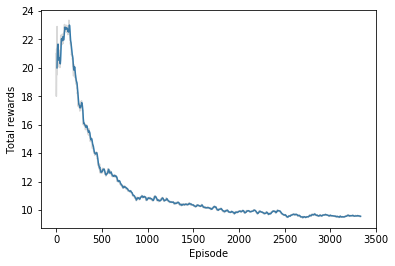

In [19]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

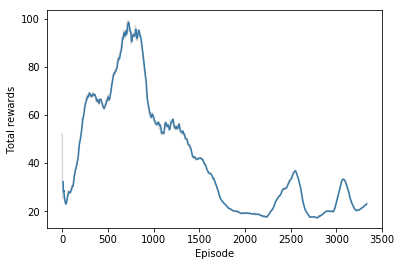

In [83]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

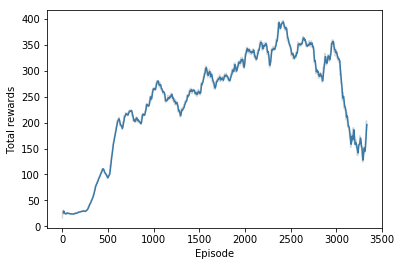

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

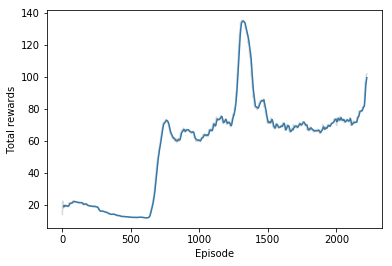

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

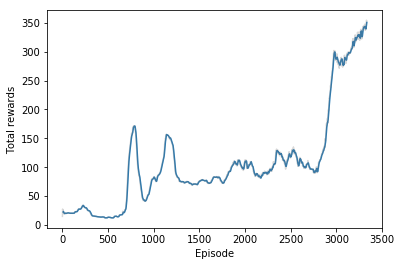

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

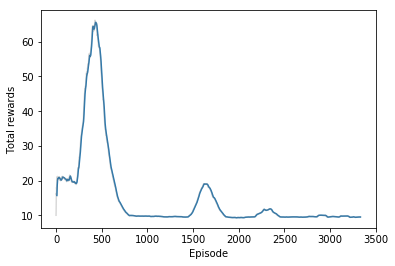

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

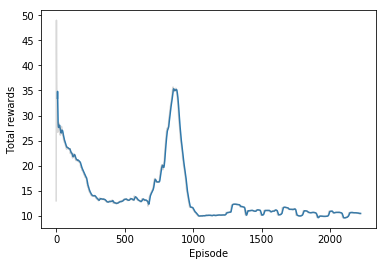

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

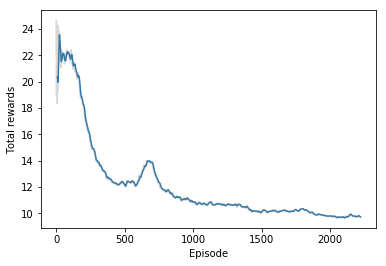

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

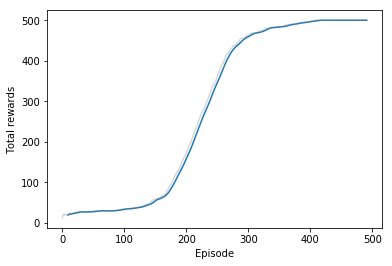

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

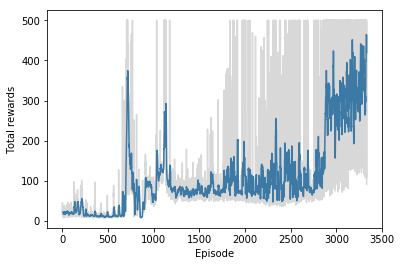

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

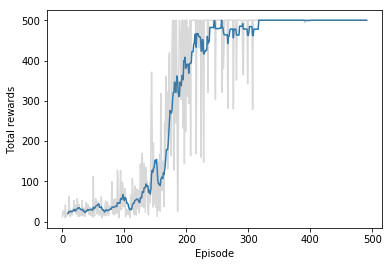

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.